In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/job_exam/poem-classification

/content/drive/MyDrive/job_exam/poem-classification


In [3]:
!pip install opendatasets
!pip install seaborn
!pip install scikit-learn
!pip install arabic_reshaper
!pip install python-bidi
!pip install pyarabic
!pip install nltk
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224

In [4]:
# import the packages.
import opendatasets as od
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pyarabic.araby as araby
import pyarabic.trans as trans
import nltk as nltk
from nltk.stem import ISRIStemmer
nltk.download("stopwords")
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score, ConfusionMatrixDisplay,confusion_matrix
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from transformers import AutoTokenizer,TFBertForSequenceClassification
import joblib

import random
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# split the data before the analysis

In [ ]:
# Download the data, supply the kaggle token
od.download_kaggle_dataset('https://www.kaggle.com/datasets/fahd09/arabic-poetry-dataset-478-2017'
                           ,data_dir='./data')

In [ ]:
data = pd.read_csv('./data/all_poems.csv')
data.head(10)

In [ ]:
# from data info we can see that we have 58k samples one of the columns 'poem_text' has a missing value
data.info()

In [ ]:
# Change the type of poem and poet id to string, as we will not do any math on it.
data.poem_id = data.poem_id.astype(str)
data.poet_id = data.poet_id.astype(str)

In [ ]:
# Since we can't fill the missing value, we will drop it and only one sample we will drop it.
data.dropna(inplace=True)

The table below gives us alot of information:
- poem_link is unique, and does not gives us any information we can use for classification.The same for poem id, and poet_link . These features will be dropped.
- There is only 3 poem_styles
- In poem_text we can see the unique is less than the count which different from what we expect,  unique poem for each row. We can also see the freq 3 which indicate duplicates, This requires further investigation.
- There is 26 poet_cat and 652 poets.


In [ ]:
data.describe()

,poem_id,poem_link,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_link,poet_name
count,58020,58020,58020,58020,58020,58020,58020,58020,58020
unique,58020,58020,3,57693,56871,26,652,652,652
top,21,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,اذا الرتبة العليا اتك اثابة وفاروق عالي الراس...,الشاعر,العصر العباسي,173,http://www.adab.com/modules.php?name=Sh3er&doW...,ابن الرومي
freq,1,1,57893,3,17,19417,2142,2142,2142


In [ ]:
# drop all columns except poem_text, title, style and category and poet name.
data.drop(columns=data.columns[~data.columns.isin(['poem_text','poem_title','poet_name','poem_style','poet_cat'])]\
          ,axis=0,inplace=True)

In [ ]:
# number of duplicates in 
data[['poem_text']].duplicated().sum()

327

In [ ]:
# checking the length of each poem
data['poem_text'].apply(lambda x: len(x)).sort_values()[:10]

15448     1
13798     9
2369     12
2240     15
2186     17
2188     18
30948    18
13945    19
38558    19
25858    19
Name: poem_text, dtype: int64

In [ ]:
# we will drop these 2 records, one is empty and one is not poem.
short_text = data[data['poem_text'].apply(lambda x: len(x)<10)]['poem_text']
short_text
data.drop(index=short_text.index,inplace=True)

In [ ]:
# Can it be usefull feature.
avg_poem_len_per_poet = data.groupby(['poet_cat'])['poem_text'].apply(lambda x: int(len(re.findall(r'\w+',' '.join(x)))/len(x)))


In [ ]:
# checking the styles count
# the dash sign could indicate a missing value and the poem belong to one of the other styles.
data.groupby('poem_style')['poem_style'].count()

poem_style
-          33
عامي       94
فصحى    57891
Name: poem_style, dtype: int64

In [ ]:
# checking the poem style -
for t in data[data.poem_style == '-']['poem_text']:
    print(t)
    print('\n')
    

 هم اكسبوك من السباق رهانا فربحت انت وادركوا الخسرانا هم اوصلوك الي مناك بغدرهم فاذقتهم فوق الهوان هوانا اني لارجو ان تكون بنارهم لما رموك بها بلغت جنانا غدروا بشيبتك الكريمة جهرة ابشر فقد اورثتهم خذلانا اهل الاساءة هم ولكن مادروا كم قدموا لشموخك الاحسانا لقب الشهادة مطمح لم تدخر وسعا لتحمله فكنت وكانا يا احمد الياسين كنت مفوها بالصمت كانا الصمت منك بيانا ما كنت لاهمة وعزيمة وشموخ صبر اعجز العدوانا فرحي بنيل مناك يمزج دمعتي بشارتي ويخف الاحزانا وثقت باله اتصالك حينما صليت فجرك تطلب الغفرانا وتلوت ايات الكتاب مرتلا متاملا تدبر القرانا وضعت جبهتك الكريمة ساجدا ان السجود ليرفع الانسانا وخرجت يتبعك الاحبة مادروا ان الفراق من الاحبة حانا كرسيك المتحرك اختصر المدي وطوي بك الافاق ولازمانا علمته معني الاباء فلم يكن مثل الكراسي الراجفات هوانا معك استلذ الموت صار وفاءه مثلا وصار اباءه عنوانا اشلا ء كرسي البطولة شاهد عدل يدين الغادر الخوانا لكاني ابصرت في عجلاته الما لفقدك لوعة وحنانا حزنا الانك قد رحلت ولم تعد تمشي به كالطواد لا تواني اني لتسالني العدالة بعدما لقيت جحود القوم والنكرانا هل ابصرت 

In [ ]:
# After checking the poems of '-' style, they all belong to 'فصحى' style, so I will change their style.
data.loc[data[data.poem_style == '-'].index,['poem_style']] = 'فصحى'

In [ ]:
# drop duplicate poems
data['poem_text'].drop_duplicates(inplace=True)


# EDA

In [ ]:
# Fixes the right to left writting in matplotlib.
def fix_arabic_string(labels):
    new_string = []
    for label in labels:
        
        if isinstance(label,str):
            new_string.append(get_display(arabic_reshaper.reshape(label)))
        else:
            new_string.append(get_display(arabic_reshaper.reshape(label.get_text())))
    return new_string

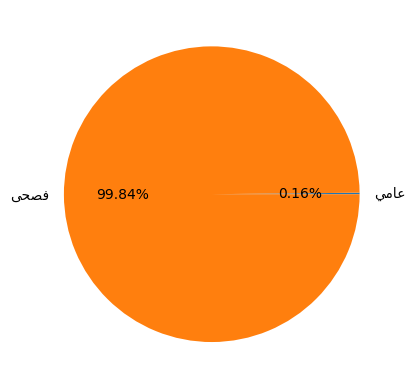

In [ ]:

poem_styles = data.groupby('poem_style')['poem_style'].count()
plt.pie(poem_styles.values, labels = fix_arabic_string(poem_styles.keys()), autopct='%.2f%%');

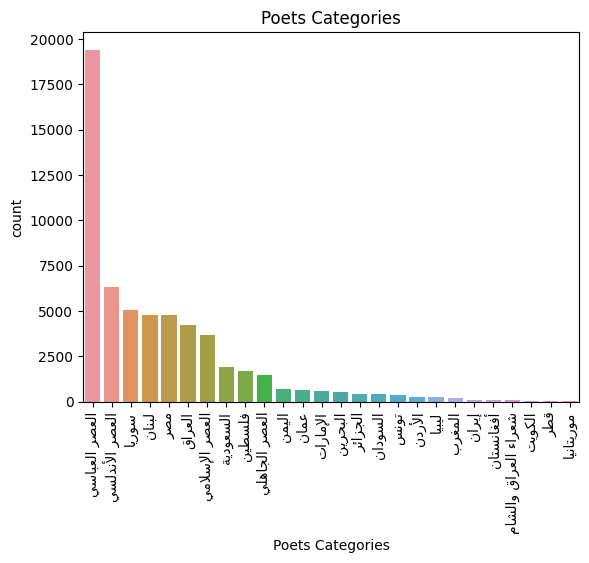

In [ ]:
ax = sns.countplot(data=data,x='poet_cat',order = data['poet_cat'].value_counts().index)
plt.title('Poets Categories')
plt.xticks(rotation=90);
ax.set_xticklabels(fix_arabic_string(ax.get_xticklabels()));
plt.xlabel('Poets Categories');

I will group all the countries from the current era to 'العصر الحديث'. The categories are of different groups, some of the categories are eras while others are countries, if we are intreseted in identifying the countries we can train 2 models, one identify the era and if the poems from the modren era it will be passed to the second model to classify the country.  

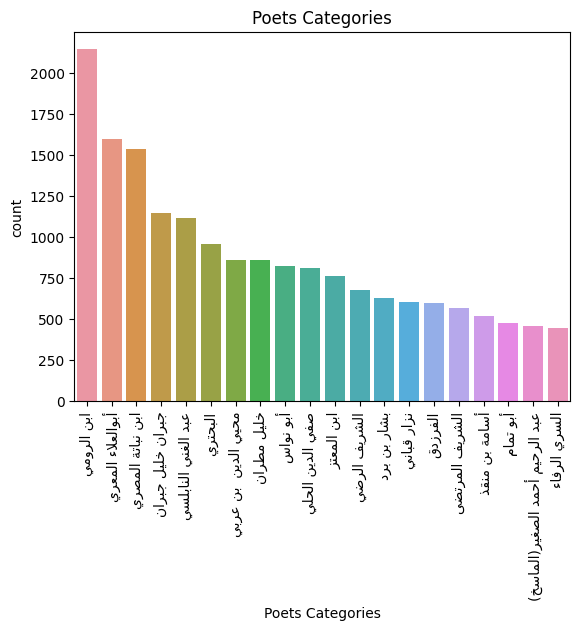

In [ ]:
# number of poets in each country.
ax = sns.countplot(data=data,x='poet_name',order = data['poet_name'].value_counts().index[:20])
plt.title('Poets Categories')
plt.xticks(rotation=90);
ax.set_xticklabels(fix_arabic_string(ax.get_xticklabels()));
plt.xlabel('Poets Categories');

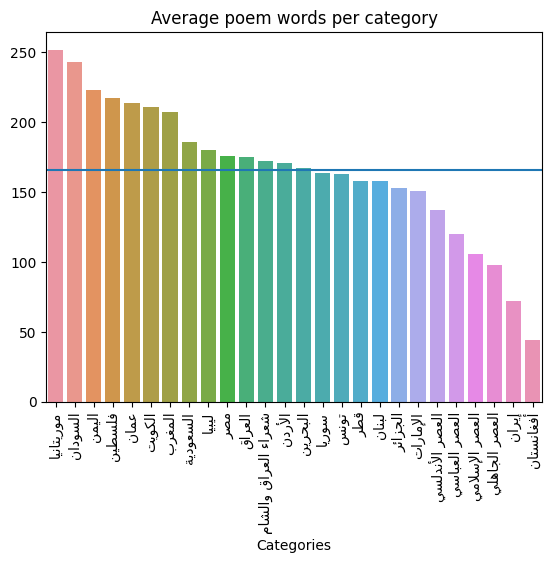

In [ ]:
sorted_values = avg_poem_len_per_poet.sort_values(ascending=False)
ax = sns.barplot(x= sorted_values.index,y=sorted_values.values)
plt.axhline(y= avg_poem_len_per_poet.mean())

plt.title('Average poem words per category')
plt.xticks(rotation=90);
ax.set_xticklabels(fix_arabic_string(ax.get_xticklabels()));
plt.xlabel('Categories');

# Preprocessing Text

Since 'عامي' style compose less then 1% I will drop these samples, they are different then the majority.

In [ ]:
data.drop(index = data[data['poem_style'] == 'عامي'].index,inplace=True)

In [ ]:
# change the countries to an era.
eras = ['العصر الجاهلي','العصر الأندلسي','العصر الإسلامي','العصر العباسي']
data.loc[data[~data['poet_cat'].isin(eras)].index,['poet_cat']] = 'العصر الحديث'
data.groupby('poet_cat')['poet_cat'].count()

poet_cat
العصر الأندلسي     6296
العصر الإسلامي     3700
العصر الجاهلي      1461
العصر الحديث      27053
العصر العباسي     19414
Name: poet_cat, dtype: int64

In [ ]:
# Some poems are mix of arabic and english
data[data.poet_name == 'إبراهيم العريض'].loc[40577]['poem_text']

'How star - like are ye Bards of Yore Alone, You heard the silent music of the spheres, And gave it living voice Through smiles and tears, Courting al mortals in their daily drone, The thought, The magic touch, The manly tone With which you season d human hopes and fears Were closely alied, naught to us apears, In Truth, but interwoven with our own Alas No more for us that inward blis Whose warmth is felt not sen, that iner glow Akin to love; Nor dare we like them, even Discern a right The lovely things we mis An artlesnes which only Art can know No more that spark, giving a glimpse of heaven ترجمه كيف نجمة - مثلك برادع الماضي علي حدة سمع_ بموسيقي الاجواء الصامتة و اعطاه صوتا حيا من خلال ابتسامات و دمع يغري كل البشر في يعسوبهم اليومي الفكرة المسة السحرية النغمة الرجولية مع الذي تبل امال انسان d و مخاوف كان عن كثب صفرا متحالفا الينا يظهر في حقيقة الا ان متشابك مع ملكنا وا اسفاه لا الكثير لنا تلك النعمة الداخلية الذي دفءه يتحس ليس sen ان داخلي توهج قريب الي محبة ولا يحتمل يودهم حتي ميز ي

In [ ]:
# removing symbols, number, diacritics,english text and extra spaces from poem_text
def remove_symbls(df):
    
    for index in df.index:
        # the cleaning is done on only the poem text, I will not be using the title in training.
        new_text = re.sub(r'\W+|\d+|_|\||[a-zA-Z]',' ', df.loc[index]['poem_text'])
        new_text = araby.normalize_hamza(new_text,method="tasheel")
        
        new_text = araby.strip_tashkeel(new_text)
        new_text = re.sub(r'\s+',' ',new_text.strip())
        df.loc[index,['poem_text']] = new_text
        
    return df

cleaned_data = remove_symbls(data.copy())



In [ ]:
print(cleaned_data.poem_text.duplicated().sum())
cleaned_data.drop(index=cleaned_data[cleaned_data['poem_text'].duplicated()].index,inplace=True)

350


In [ ]:
# removing stopwords,  and perform stemming on the words.
def stemming(df):
    stemmer = ISRIStemmer()
    stopwords = nltk.corpus.stopwords.words()
    for index in df.index:
        text=''
        for token in araby.tokenize(df.loc[index]['poem_text'],morphs=araby.strip_tashkeel):
            
            if token not in stopwords:
                #change the word to its root, to reduce the number of features.
                text+=stemmer.stem(token)+' '
                
        # removing extra white spaces.
        new_text = re.sub(r'\s+',' ',text.strip())
        df.loc[index,['poem_text']] = new_text
    return df

In [ ]:
#cleaned_data = stemming(cleaned_data.copy())

In [ ]:
#cleaned_data.to_csv('cleaned_data_without_stem.csv',index=False)
# the data is saved after cleaning to avoid going though the same slow process.
cleaned_data_with_stem = pd.read_csv('./data/cleaned_data_with_stem.csv')

# ML

#### Baseline NB
- First, we will start by training NB and logistic regression, because it is simpler and faster than training NN, and based on the performance we can decide. I don't think this will yield a good performance, because we are classifying based on the presence or absence of words, and ignoring the context and style of the poem.  

In [ ]:
#split the data into train,test
x_train,x_test,y_train,y_test = train_test_split(cleaned_data_with_stem.poem_text,
                                                 cleaned_data_with_stem.poet_cat,
                                                 test_size=0.2,random_state=1,shuffle=True)


In [ ]:
#Encoding the class labels.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# Checking the training and testing size.
len(x_train),len(x_test)

(46066, 11517)

In [ ]:
vectorizer = CountVectorizer()
x_train_vect= vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

In [5]:
english_labels = ['Andalusian era','Islamic era','Pre-Islamic era','Modren era','Abbasid era']

In [ ]:
nb = MultinomialNB()
nb.fit(x_train_vect,y_train)
test_pred = nb.predict(x_test_vect)
train_pred = nb.predict(x_train_vect)

In [ ]:
# naive bayes has high bais and low variance, that is why it was not affected by the high dimensionality 
print('Training accuracy: ',round(accuracy_score(y_train,train_pred),2))
print('Testing accuracy: ',round(accuracy_score(y_test,test_pred),2))

Training accuracy:  0.72
Testing accuracy:  0.69


In [ ]:
print('Naive Bayes Results')
print(classification_report(y_test,test_pred,target_names=english_labels))

Naive Bayes Results
                 precision    recall  f1-score   support

 Andalusian era       0.42      0.42      0.42      1250
    Islamic era       0.62      0.42      0.50       756
Pre-Islamic era       0.78      0.02      0.05       291
     Modren era       0.85      0.77      0.81      5385
    Abbasid era       0.61      0.78      0.69      3835

       accuracy                           0.69     11517
      macro avg       0.66      0.48      0.49     11517
   weighted avg       0.71      0.69      0.69     11517



In [ ]:
# logistic regression has low bais and high variance, thus we need to add regularization
lr = LogisticRegression(C=0.1)
lr.fit(x_train_vect,y_train)
test_pred = lr.predict(x_test_vect)
train_pred = lr.predict(x_train_vect)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Training accuracy: ',round(accuracy_score(y_train,train_pred),2))
print('Testing accuracy: ',round(accuracy_score(y_test,test_pred),2))

Training accuracy:  0.85
Testing accuracy:  0.74


In [ ]:
print('Logistic Regression Results:')
print(classification_report(y_test,test_pred,target_names=english_labels))

Logistic Regression Results:
                 precision    recall  f1-score   support

 Andalusian era       0.59      0.33      0.43      1250
    Islamic era       0.65      0.41      0.50       756
Pre-Islamic era       0.61      0.26      0.37       291
     Modren era       0.87      0.86      0.86      5385
    Abbasid era       0.65      0.83      0.73      3835

       accuracy                           0.74     11517
      macro avg       0.67      0.54      0.58     11517
   weighted avg       0.74      0.74      0.73     11517



In [ ]:
# saving the best model
joblib.dump(lr, './best-model/logistic_regression_model.joblib')

['./logistic_regression_model.joblib']

In [ ]:
# load the model
lr = joblib.load('./best-model/logistic_regression_model.joblib')

### Pre-trained bert

In [6]:
# load the cleaned data without stemming
cleaned_data = pd.read_csv('./data/cleaned_data.csv')

In [7]:
cleaned_data['poet_cat'].value_counts()

العصر الحديث      26733
العصر العباسي     19397
العصر الأندلسي     6291
العصر الإسلامي     3696
العصر الجاهلي      1457
Name: poet_cat, dtype: int64

In [8]:
#split the data into train,test and val

x_train,x_test,y_train,y_test = train_test_split(cleaned_data.poem_text,
                                                 cleaned_data.poet_cat,
                                                 test_size=0.2,random_state=2,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train,
                                                y_train,
                                                 test_size=0.25,random_state=2,shuffle=True)

In [9]:
#Encoding the class labels.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [10]:
# load arabnet pretrained on millions of arabic news.
model_name = "aubmindlab/bert-base-arabertv02"
model = TFBertForSequenceClassification.from_pretrained(model_name,num_labels=len(label_encoder.classes_),problem_type = "classification",return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
train_encodings = tokenizer(x_train.to_list(), max_length=128,
          padding='max_length',
          truncation=True)
val_encodings = tokenizer(x_val.to_list(),  max_length=128,
          padding='max_length',
          truncation=True)
test_encodings = tokenizer(x_test.to_list(),  max_length=128,
          padding='max_length',
          truncation=True)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:

# save the best model.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/job_exam/poem-classification/best_model',
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# using AdamW with, using the weight_decay we can reduce the overfitting.
# the weight decay set it to 0.05
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5, epsilon=1e-08,weight_decay=0.05)
# compile the model
model.compile(optimizer=optimizer,loss=loss,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()
                       ])
# train the model
history = model.fit(train_dataset.batch(16),
              epochs=4,
              batch_size=16,
              validation_data=val_dataset.batch(16),callbacks=[model_checkpoint])

Epoch 1/4
2159/2159 [==============================] - 628s 258ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.7369
Epoch 2/4
2159/2159 [==============================] - 462s 214ms/step - loss: 0.5678 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.6428 - val_sparse_categorical_accuracy: 0.7536
Epoch 3/4
2159/2159 [==============================] - 452s 209ms/step - loss: 0.4349 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.7442
Epoch 4/4
2159/2159 [==============================] - 435s 202ms/step - loss: 0.3241 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.7239


# Results

In [ ]:
# load bert model to load the saved weights
model_name = "aubmindlab/bert-base-arabertv02"
model = TFBertForSequenceClassification.from_pretrained(model_name,num_labels=len(label_encoder.classes_),problem_type = "classification",return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# load the weights
model.load_weights('./best_model')

In [15]:
def predict(data):
  preds = model.predict(data.batch(16))["logits"]
  class_preds = np.argmax(preds, axis=1)
  y_true = [y for x, y in data.as_numpy_iterator()]
  return y_true,class_preds

In [16]:
# predict on validation set
val_true,val_pred = predict(val_dataset)

720/720 [==============================] - 26s 26ms/step


In [17]:
# results on the validation dataset.
print(classification_report(val_true,val_pred,target_names=english_labels))

                 precision    recall  f1-score   support

 Andalusian era       0.44      0.40      0.42      1251
    Islamic era       0.61      0.50      0.55       740
Pre-Islamic era       0.56      0.05      0.09       290
     Modren era       0.89      0.88      0.89      5363
    Abbasid era       0.69      0.79      0.73      3871

       accuracy                           0.75     11515
      macro avg       0.64      0.52      0.54     11515
   weighted avg       0.75      0.75      0.74     11515



In [18]:
# predict on test set.
test_true,test_pred = predict(test_dataset)

720/720 [==============================] - 19s 26ms/step


In [19]:
# results on the test dataset.
print(classification_report(test_true,test_pred,target_names=english_labels))

                 precision    recall  f1-score   support

 Andalusian era       0.47      0.40      0.43      1242
    Islamic era       0.59      0.47      0.52       760
Pre-Islamic era       0.42      0.04      0.07       284
     Modren era       0.90      0.89      0.90      5401
    Abbasid era       0.68      0.79      0.73      3828

       accuracy                           0.76     11515
      macro avg       0.61      0.52      0.53     11515
   weighted avg       0.75      0.76      0.75     11515



- The performance of fine-tuned arabert is slightly better then logistic regression the change is approximatly 2.7%. still, the results are affected by the data imbalance. The class with heighest number of samples is Modren era, followed by Abbasid era, which both have the top f1-score. The lowest is Pre-Islamic era which has the lowest number of samples in the trainig set of 1400.
- The weighted accuracy change calculated using this equation:
  - ((new_accuracy-old_accuracy)/old_accuracy) *100

<Figure size 800x800 with 0 Axes>

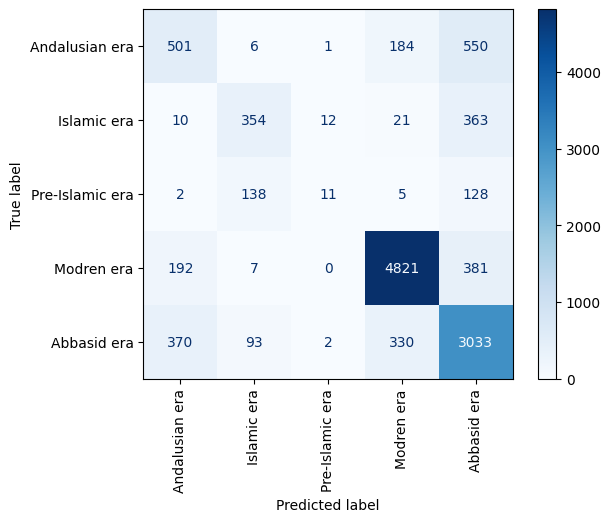

In [20]:
# plotting the confusion matrix
fig = plt.figure(figsize=(8,8))
cm = confusion_matrix(y_true=test_true,y_pred=test_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=english_labels)

cmd.plot(cmap=plt.cm.Blues,xticks_rotation='vertical');

There is high misclassifcation between Abbasid era and Andalusian era possible because of the overlap in the eras, abbasid era from 750 to 1258 wheras Andalusian era was from 711 to 1492, the poems writting styles and topics may be similar. The pre-islamic era has the lowest correct recall because of the small size of the dataset. So we will train our model again using the best hyperparameters we found on the train and val to increase the size of the dataset.

# Retrain the model using the best hyperparameters on both the train and val set.

In [21]:
# load arabnet pretrained on millions of arabic news.
model_name = "aubmindlab/bert-base-arabertv02"
model = TFBertForSequenceClassification.from_pretrained(model_name,num_labels=len(label_encoder.classes_),problem_type = "classification",return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#split the data into train andtest

x_train,x_test,y_train,y_test = train_test_split(cleaned_data.poem_text,
                                                 cleaned_data.poet_cat,
                                                 test_size=0.2,random_state=2,shuffle=True)


In [23]:
#Encoding the class labels.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [24]:
train_encodings = tokenizer(x_train.to_list(), max_length=128,
          padding='max_length',
          truncation=True)

test_encodings = tokenizer(x_test.to_list(),  max_length=128,
          padding='max_length',
          truncation=True)

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))


test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test #here was the error
))

In [30]:
# Retrain the model using the best hyperparameters, the best number of epoachs are 3 or 4 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# using AdamW with, using the weight_decay we can reduce the overfitting.
# the weight decay set it to 0.05
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5, epsilon=1e-08,weight_decay=0.05)
# compile the model
model.compile(optimizer=optimizer,loss=loss,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()
                       ])
# train the model
history = model.fit(train_dataset.batch(16),
              epochs=1,
              batch_size=16)

2879/2879 [==============================] - 322s 95ms/step - loss: 0.2987 - sparse_categorical_accuracy: 0.8903


In [31]:
# predict on test set.
test_true,test_pred = predict(test_dataset)

720/720 [==============================] - 22s 26ms/step


In [32]:
# results on the test dataset.
print(classification_report(test_true,test_pred,target_names=english_labels))


                 precision    recall  f1-score   support

 Andalusian era       0.46      0.43      0.44      1242
    Islamic era       0.63      0.48      0.54       760
Pre-Islamic era       0.50      0.18      0.26       284
     Modren era       0.88      0.92      0.90      5401
    Abbasid era       0.70      0.75      0.72      3828

       accuracy                           0.76     11515
      macro avg       0.63      0.55      0.57     11515
   weighted avg       0.75      0.76      0.75     11515



After retraining on both train and validation we see the pre-islamic era has better recall, The other classes f1 score decreased slightly. 

<Figure size 800x800 with 0 Axes>

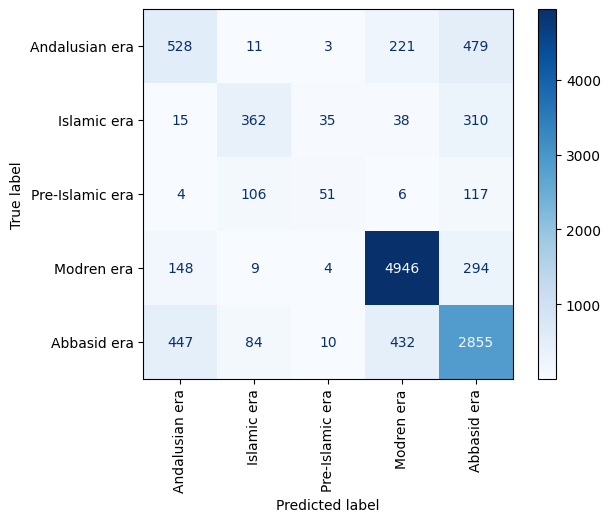

In [33]:
# plotting the confusion matrix
fig = plt.figure(figsize=(8,8))
cm = confusion_matrix(y_true=test_true,y_pred=test_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=english_labels)

cmd.plot(cmap=plt.cm.Blues,xticks_rotation='vertical');

The data is imbalanced, and in all models we see the same behaviour, the modren era class has better classification then the other classes, because it is the majority class.

Future work:
- use Cross validation to ensure the generalizablity of the model. 
- To improve the performance use model trained on poetry since we are dealing with small data, add more data by scraping poetry websites 
- to deal with the imbalance assign different weights to the classes.
- create a pipline for the preprocessing done on the data.